In [3]:
import radarsimpy

print("`RadarSimPy` used in this example is version: " + str(radarsimpy.__version__))

`RadarSimPy` used in this example is version: 14.1.0


# Phase Noise Simulation

## Introduction

This notebook demonstrates **RadarSimPy's phase noise simulation capabilities** for FMCW radar systems. Phase noise—random variations in signal phase—significantly impacts radar performance, and RadarSimPy enables accurate modeling of these effects.

**What You'll Learn:**

- Use RadarSimPy's `Transmitter` class with phase noise parameters
- Configure phase noise using measured frequency-domain data
- Compare radar performance with and without phase noise
- Process simulated data with RadarSimPy's signal processing functions
- Analyze phase noise effects on range profile and dynamic range

**Key RadarSimPy Features Demonstrated:**

- **Phase noise modeling**: `pn_f` and `pn_power` parameters in `Transmitter`
- **Side-by-side comparison**: Simulate identical systems with/without phase noise
- **Realistic effects**: Observe range shoulder artifacts and dynamic range reduction

**Why This Matters:** Phase noise is critical for radar system design. RadarSimPy lets you evaluate phase noise requirements before selecting hardware components.

### Phase Noise Impact on FMCW Radar

Phase noise affects radar performance in several ways:

1. **Range Profile Degradation**: Creates "shoulders" around strong targets
2. **Dynamic Range Reduction**: Weak targets near strong ones may be masked
3. **Doppler Accuracy**: Phase variations introduce velocity measurement errors
4. **SNR Reduction**: Phase noise contributes to overall system noise

**RadarSimPy enables quantitative assessment** of these effects using measured phase noise data from oscillators or synthesizers.

## Configure Phase Noise Data for RadarSimPy

RadarSimPy accepts phase noise as two arrays:
- **`pn_f`**: Frequency offset from carrier (Hz)
- **`pn_power`**: Single-sideband phase noise power density (dBc/Hz)

This data typically comes from oscillator/synthesizer datasheets or measurements.

**Phase Noise Data Source:**
- The example data is located in [data/phase_noise.csv](https://github.com/radarsimx/radarsimnb/blob/master/notebooks/data/phase_noise.csv) in the notebook directory
- This CSV file contains two columns: `Frequency` (Hz) and `Power` (dBc/Hz)
- You can replace this with your own phase noise data from oscillator datasheets or measurements


In [ ]:
import numpy as np
import pandas as pd
import os

# Load phase noise data from CSV file
data_path = os.path.join(os.getcwd(), "data", "phase_noise.csv")
df = pd.read_csv(data_path)

phase_noise_freq = df["Frequency"].to_numpy()
phase_noise_power = df["Power"].to_numpy()

### Visualize Phase Noise Profile


Plot the phase noise profile that will be used in RadarSimPy simulation.

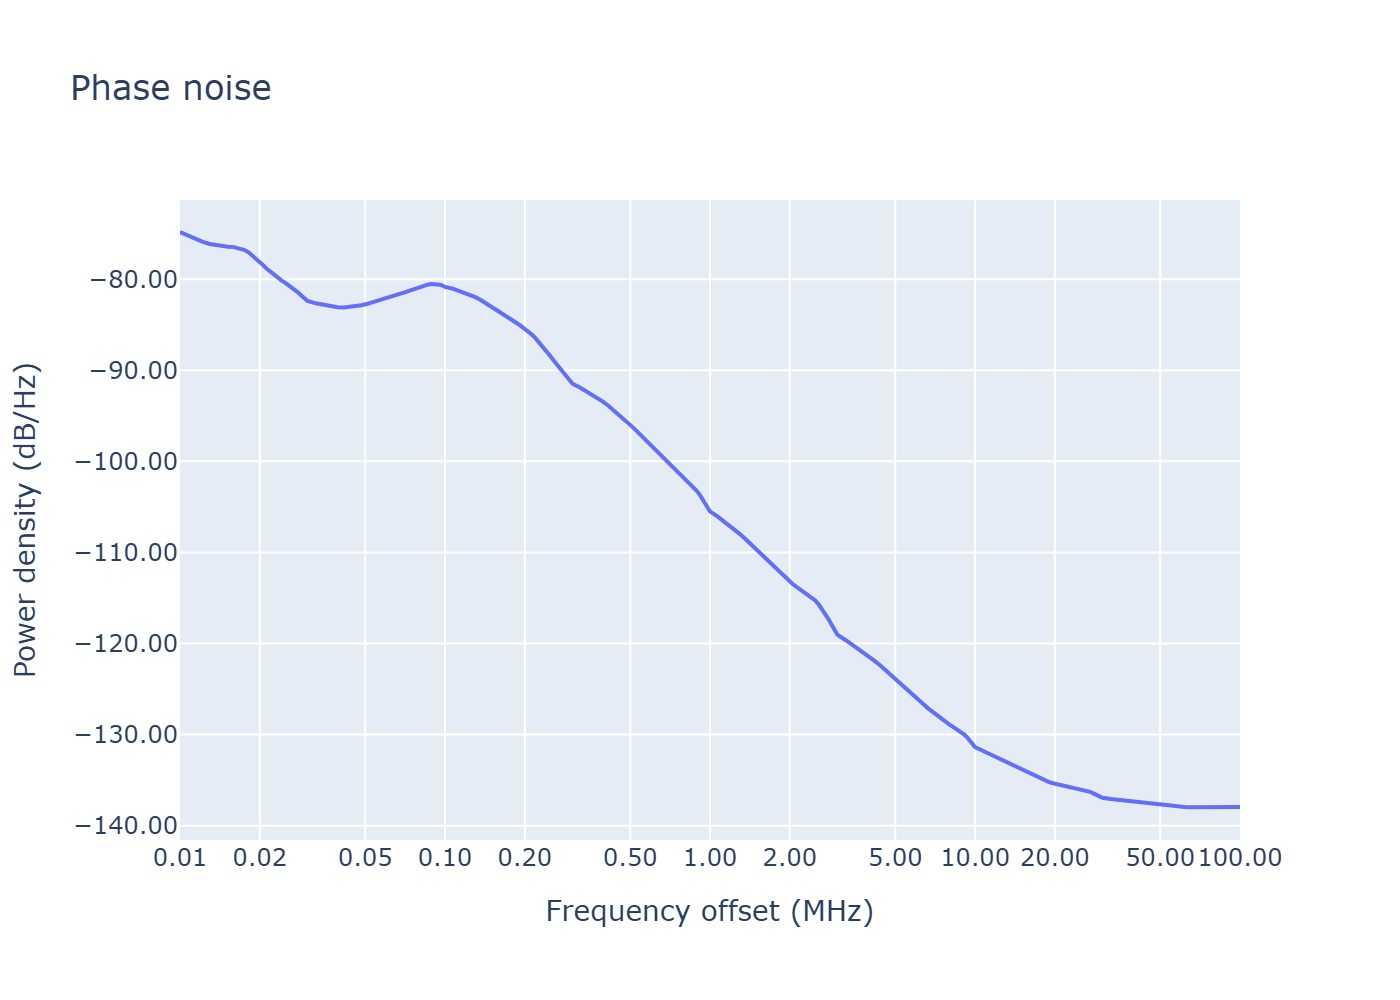

In [5]:
import plotly.graph_objs as go
from IPython.display import Image

fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=phase_noise_freq / 1000000,
        y=phase_noise_power,
        name="Phase noise",
    )
)
fig.update_layout(
    title="Phase noise",
    yaxis=dict(tickformat=".2f", title="Power density (dB/Hz)"),
    xaxis=dict(tickformat=".2f", title="Frequency offset (MHz)", type="log"),
)

# uncomment this to display interactive plot
# fig.show()

# display static image to reduce size on radarsimx.com
img_bytes = fig.to_image(format="jpg", scale=2)
display(Image(img_bytes))

## Build RadarSimPy Radar Models

### Configure Transmitters with RadarSimPy

Create two `Transmitter` objects for comparison:
- **`tx_pn`**: With phase noise (using `pn_f` and `pn_power` parameters)
- **`tx`**: Without phase noise (baseline for comparison)

**Key RadarSimPy Phase Noise Parameters:**

- `pn_f`: Array of frequency offsets
- `pn_power`: Array of phase noise power density values

In [6]:
from radarsimpy import Radar, Transmitter, Receiver

tx_channel = dict(
    location=(0, 0, 0),
)

tx_pn = Transmitter(
    f=[24.125e9 - 50e6, 24.125e9 + 50e6],
    t=80e-6,
    tx_power=20,
    prp=100e-6,
    pulses=128,
    pn_f=phase_noise_freq,
    pn_power=phase_noise_power,
    channels=[tx_channel],
)

tx = Transmitter(
    f=[24.125e9 - 50e6, 24.125e9 + 50e6],
    t=80e-6,
    tx_power=20,
    prp=100e-6,
    pulses=128,
    channels=[tx_channel],
)

### Configure Receiver with RadarSimPy

Define receiver parameters using RadarSimPy's `Receiver` class.


In [7]:
rx_channel = dict(
    location=(0, 0, 0),
)

rx = Receiver(
    fs=2e6,
    noise_figure=12,
    rf_gain=20,
    load_resistor=500,
    baseband_gain=30,
    channels=[rx_channel],
)

### Assemble Radar Systems

Combine transmitters and receiver into complete radar systems using RadarSimPy's `Radar` class:
- **`radar_pn`**: With phase noise
- **`radar`**: Without phase noise (baseline)


In [8]:
radar_pn = Radar(transmitter=tx_pn, receiver=rx)
radar = Radar(transmitter=tx, receiver=rx)

### Define Point Targets

Configure two point targets with different RCS values to demonstrate phase noise effects on dynamic range:


In [9]:
target_1 = dict(location=(150, 20, 0), speed=(0, 0, 0), rcs=70, phase=0)
target_2 = dict(location=(80, -5, 0), speed=(0, 0, 0), rcs=40, phase=0)

targets = [target_1, target_2]

## Run RadarSimPy Simulations

Use `sim_radar()` to simulate both radar systems with identical targets. This allows direct comparison of phase noise effects.

**RadarSimPy Output:**
- `timestamp`: Time values for each sample
- `baseband`: Target return signals
- `noise`: Receiver thermal noise


In [10]:
from radarsimpy.simulator import sim_radar

raw_data_pn = sim_radar(radar_pn, targets)
time_matrix_pn = raw_data_pn["timestamp"]
data_matrix_pn = raw_data_pn["baseband"] + raw_data_pn["noise"]

raw_data = sim_radar(radar, targets)
time_matrix = raw_data["timestamp"]
data_matrix = raw_data["baseband"] + raw_data["noise"]

## Process with RadarSimPy Signal Processing

### Range Profile Computation

Use RadarSimPy's `range_fft()` function to compute range profiles from both simulations.


In [ ]:
from scipy import signal, constants
import radarsimpy.processing as proc

range_window = signal.windows.chebwin(radar.sample_prop["samples_per_pulse"], at=60)

range_profile_pn = proc.range_fft(data_matrix_pn, range_window)
range_profile = proc.range_fft(data_matrix, range_window)

### Compare Range Profiles


Visualize the phase noise impact by comparing range profiles from both simulations.

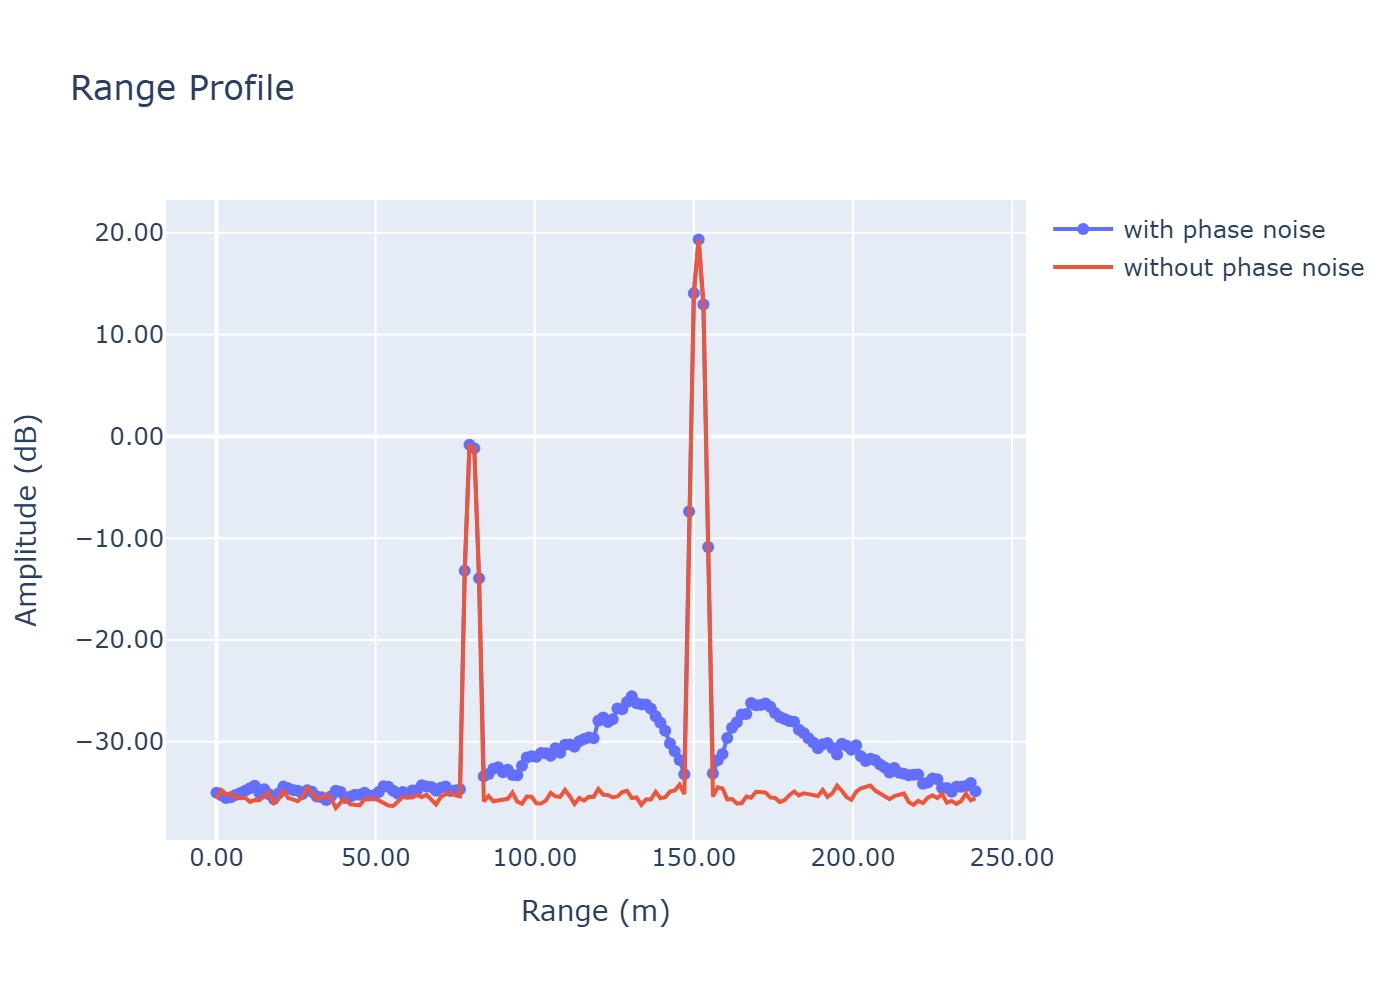

In [ ]:
max_range = (
    constants.c
    * radar.radar_prop["receiver"].bb_prop["fs"]
    * radar.radar_prop["transmitter"].waveform_prop["pulse_length"]
    / radar.radar_prop["transmitter"].waveform_prop["bandwidth"]
    / 2
)
range_axis = np.linspace(
    0, max_range, radar.sample_prop["samples_per_pulse"], endpoint=False
)

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=range_axis,
        y=20 * np.log10(np.mean(np.abs(range_profile_pn[0, :, :]), axis=0)),
        mode="lines+markers",
        name="with phase noise",
    )
)

fig.add_trace(
    go.Scatter(
        x=range_axis,
        y=20 * np.log10(np.mean(np.abs(range_profile[0, :, :]), axis=0)),
        name="without phase noise",
    )
)

fig.update_layout(
    title="Range Profile",
    yaxis=dict(tickformat=".2f", title="Amplitude (dB)"),
    xaxis=dict(tickformat=".2f", title="Range (m)"),
)

# uncomment this to display interactive plot
# fig.show()

# display static image to reduce size on radarsimx.com
img_bytes = fig.to_image(format="jpg", scale=2)
display(Image(img_bytes))

### Observe Phase Noise Effects

As shown in the plot, phase noise creates "shoulders" around strong targets:

1. **Stronger target (70 dBsm)**: Shows more pronounced shoulders
2. **Range dependency**: Shoulders increase with range due to decorrelation
3. **Dynamic range impact**: Weak targets near strong ones may be masked

**Practical Implications:**
- In automotive radar, pedestrians near vehicles could be obscured
- System dynamic range is reduced by phase noise
- Low phase noise oscillators are essential for multi-target detection

## Summary and Key Takeaways

### RadarSimPy Phase Noise Capabilities

This notebook demonstrated:

1. **Phase Noise Configuration**:
   - Use `pn_f` and `pn_power` parameters in `Transmitter`
   - Input measured phase noise data from oscillator specs
   - RadarSimPy automatically applies phase noise to simulated signals

2. **Comparative Analysis**:
   - Create identical systems with/without phase noise
   - Use `sim_radar()` for both configurations
   - Directly compare results to quantify impact

3. **Signal Processing**:
   - Process simulated data with `range_fft()`
   - Analyze range profiles to observe phase noise artifacts
   - Measure dynamic range degradation

### Key Findings

**Phase Noise Creates Range Shoulders:**
- Energy spreads from target peak into adjacent range bins
- Effect increases with target RCS and range
- Reduces system dynamic range

**Design Guidelines:**
- Lower phase noise → better dynamic range
- Critical for detecting weak targets near strong ones
- Essential in crowded environments (automotive, urban)

### Experiment Further

1. **Try different phase noise profiles**:
   - Low-cost vs. high-performance oscillators
   - Observe dynamic range trade-offs

2. **Vary target separation**:
   - Place weak target at different ranges from strong target
   - Find minimum separation for reliable detection

3. **Range-Doppler analysis**:
   - Add moving targets
   - Observe phase noise effects on Doppler resolution

4. **Quantify requirements**:
   - Define minimum dynamic range specification
   - Determine acceptable phase noise profile

### Resources

- RadarSimPy Documentation: https://radarsimx.com
- API Reference: https://radarsimx.github.io/radarsimpy/
- Transmitter phase noise parameters: `pn_f`, `pn_power`